In [18]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import joblib
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from joblib import parallel_backend

In [19]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [20]:
# Load dataset
df = pd.read_csv(r"C:\Users\psant\OneDrive\Documents\Heart_Attack_Prediction\heart_attack_prediction_dataset.csv")
print(df.columns)
print(df.dtypes)

C:\Users\psant\AppData\Local\Temp\ipykernel_16824\3334557427.py:2: DtypeWarning: Columns (0,2,4,12,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\psant\OneDrive\Documents\Heart_Attack_Prediction\heart_attack_prediction_dataset.csv")


Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')
Patient ID                          object
Age                                float64
Sex                                 object
Cholesterol                        float64
Blood Pressure                      object
Heart Rate                         float64
Diabetes                           float64
Family History                     float64
Smoking                            float64
Obesity                            float64
Alcohol Consumption                float64
Exercise Hours Per Week        

In [21]:
# Load dataset
df = pd.read_csv("heart_attack_prediction_dataset.csv")

# Data Preprocessing
df.drop(columns=['Patient ID'], inplace=True)
categorical_cols = ['Sex', 'Diet', 'Country', 'Continent', 'Hemisphere']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))

df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
df.drop(columns=['Blood Pressure'], inplace=True)
df.fillna(df.median(), inplace=True)

C:\Users\psant\AppData\Local\Temp\ipykernel_16824\2613138355.py:2: DtypeWarning: Columns (0,2,4,12,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("heart_attack_prediction_dataset.csv")


In [5]:
# Train-Test Split
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Convert to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [9]:
# Remove constant and highly correlated features
corr_matrix = X_train_resampled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
if to_drop:
    X_train_resampled.drop(columns=to_drop, inplace=True)
    X_test.drop(columns=to_drop, inplace=True)

In [10]:
# Define models with optimized hyperparameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=8, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=8),
    'CatBoost': CatBoostClassifier(iterations=100, depth=8, verbose=0)
}

In [ ]:
# Load models if they exist, otherwise train and save them
results = {}
with parallel_backend('threading', n_jobs=-1):
    for name, model in models.items():
        file_path = f"{name.replace(' ', '_')}.pkl"
        if os.path.exists(file_path):
            models[name] = joblib.load(file_path)
        else:
            model.fit(X_train_resampled, y_train_resampled)
            joblib.dump(model, file_path)
        
        y_pred = models[name].predict(X_test)

         



         
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}


In [12]:
# Display Model Performance
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.994550   0.354602  1.000000  0.523551  0.997267
KNN                  0.994569   0.354250  0.988854  0.521630  0.991720
Random Forest        0.994664   0.357184  0.977707  0.523221  0.986211
XGBoost              0.996223   0.357639  0.328025  0.342193  0.663128
LightGBM             0.995718   0.346241  0.484076  0.403718  0.740666
CatBoost             0.996037   0.376068  0.490446  0.425708  0.744001


<Figure size 1200x600 with 0 Axes>

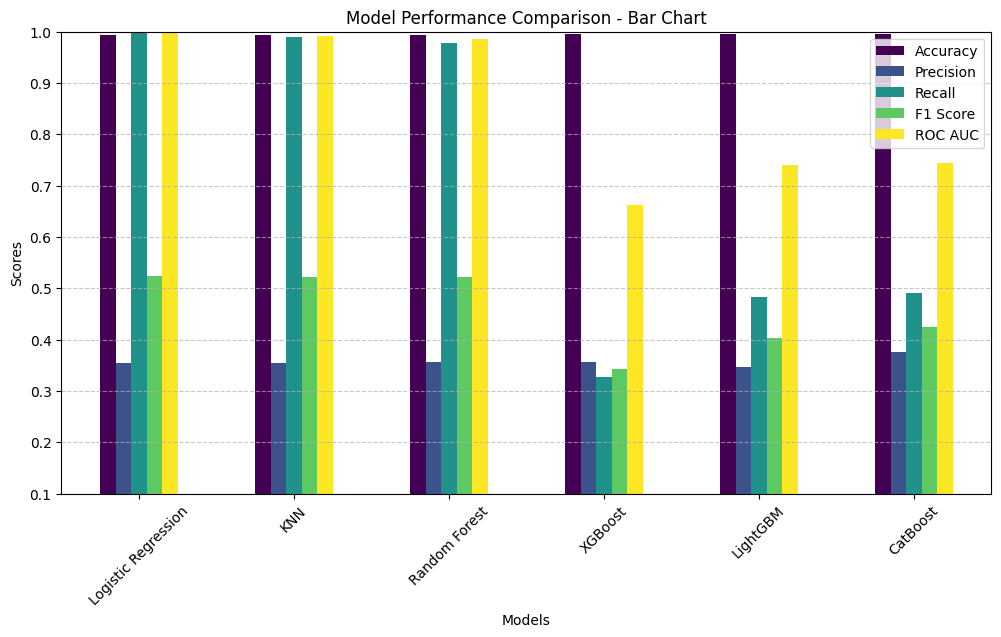

In [ ]:
# Visualization of Model Performance
import matplotlib.pyplot as plt

# Visualization of Model Performance with Adjusted Y-Axis
plt.figure(figsize=(12, 6))
ax = results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
ax.set_ylim(0.10, 1.0)  # Adjusting the Y-axis range for better visibility
plt.title("Model Performance Comparison - `Bar Chart")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

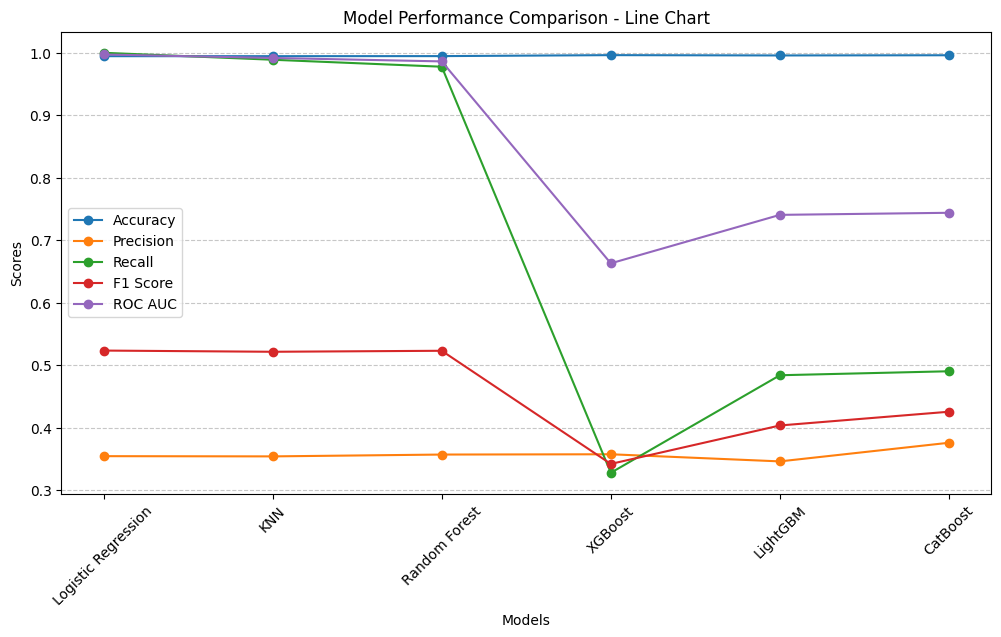

In [14]:
plt.figure(figsize=(12, 6))
for metric in results_df.columns:
    plt.plot(results_df.index, results_df[metric], marker='o', linestyle='-', label=metric)
plt.title("Model Performance Comparison - Line Chart")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1200x600 with 0 Axes>

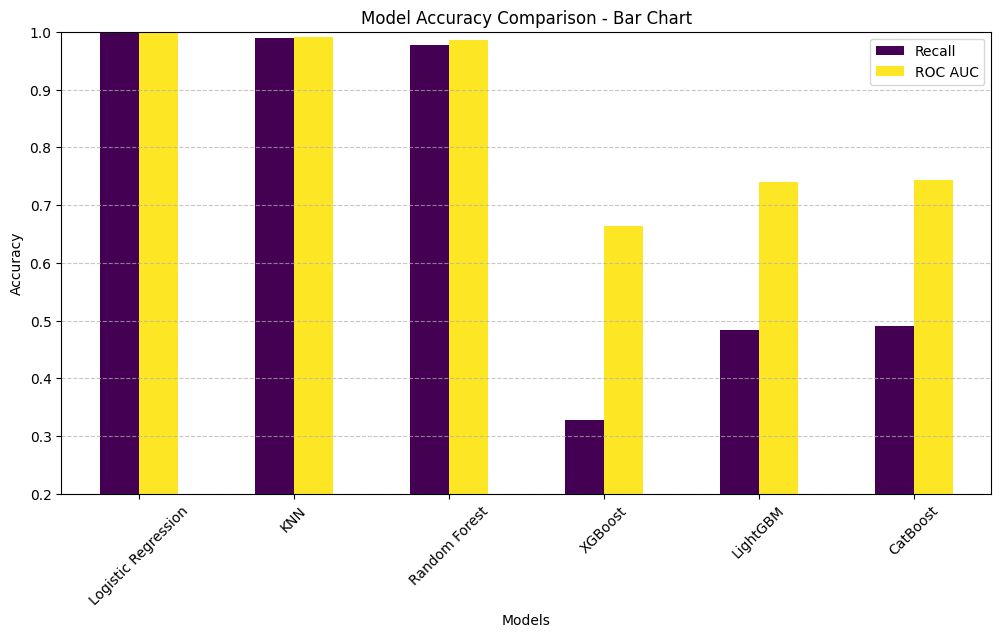

In [15]:
# Visualization of Model Performance with Adjusted Y-Axis for Accuracy
plt.figure(figsize=(12, 6))
ax = results_df[['Recall', 'ROC AUC']].plot(kind='bar', figsize=(12, 6), colormap='viridis')
ax.set_ylim(0.2, 1.0)  # Adjusting the Y-axis range for better visibility
plt.title("Model Accuracy Comparison - Bar Chart")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


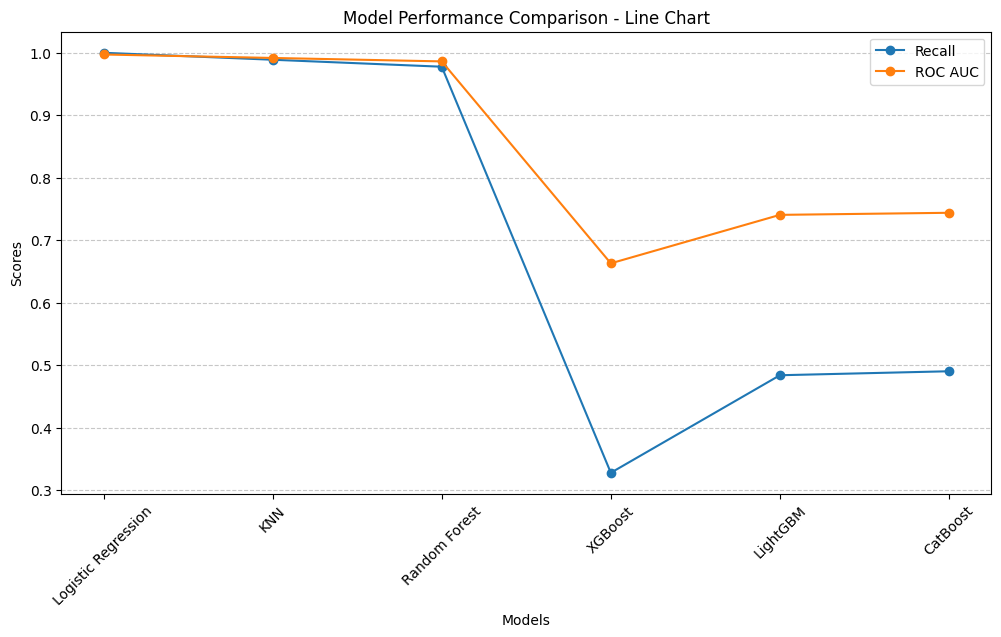

In [16]:
# Line Chart for Variation in Metrics
plt.figure(figsize=(12, 6))
for metric in ['Recall', 'ROC AUC']:
    plt.plot(results_df.index, results_df[metric], marker='o', linestyle='-', label=metric)
plt.title("Model Performance Comparison - Line Chart")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\psant\AppData\Local\Temp\ipykernel_16824\591313474.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], plot_type="bar")


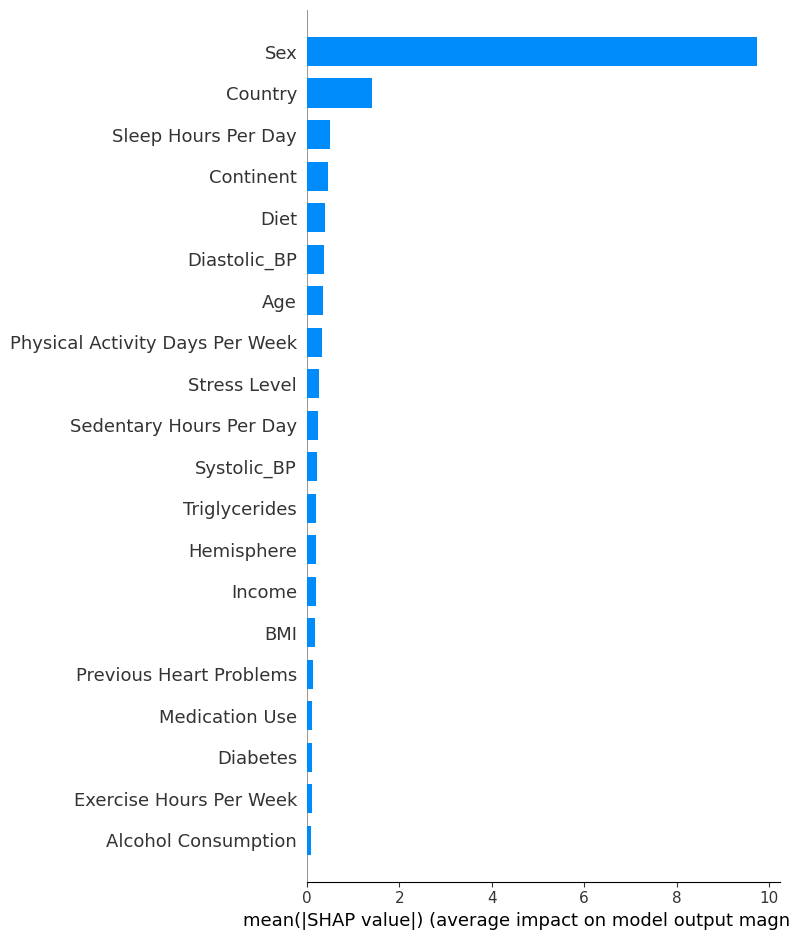

C:\Users\psant\AppData\Local\Temp\ipykernel_16824\591313474.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100])


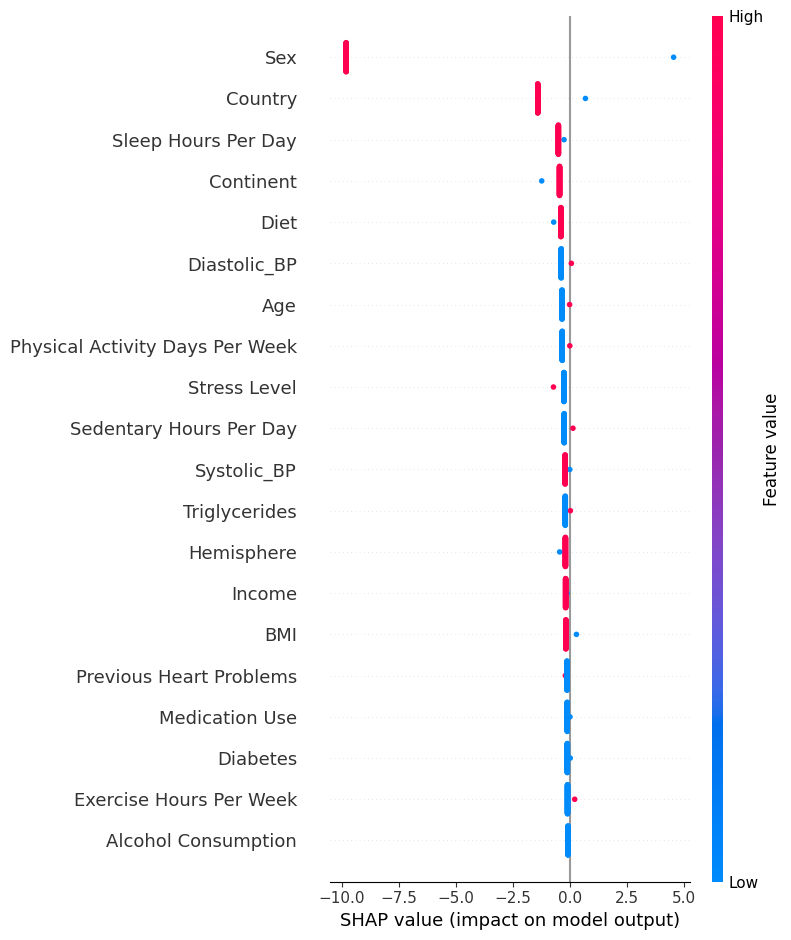

In [17]:
# SHAP Analysis
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
best_model = models[best_model_name]

# Use appropriate SHAP explainer
if isinstance(best_model, (XGBClassifier, LGBMClassifier, CatBoostClassifier, RandomForestClassifier)):
    explainer = shap.TreeExplainer(best_model)
elif isinstance(best_model, LogisticRegression):
    explainer = shap.LinearExplainer(best_model, X_train_resampled)
else:
    explainer = shap.Explainer(best_model, X_train_resampled)

shap_values = explainer.shap_values(X_test[:100])  # Using a subset for faster computation

# SHAP Summary Plot (Bar Chart for Feature Importance)
shap.summary_plot(shap_values, X_test[:100], plot_type="bar")

# SHAP Summary Plot (Bee Swarm)
shap.summary_plot(shap_values, X_test[:100])

# SHAP Force Plot (Individual Prediction Explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
